# Numerical Project : Paris Physics Master M1
#### <div align = 'center'>Evaluating the ground state of molecular hamiltonian by using the VQE ([Variational Quantum EigenSolver](https://en.wikipedia.org/wiki/Variational_quantum_eigensolver))</div>

<h4> Student 1: Murshed SK <br>
Student 2: Mohammad Sadman Tamzid Hossain <br>
Student 3: Abdelkhalek Bashandi </h4>

A potential energy curve provides the ground-state energy of a molecule as a function of the distances between its constituent atoms. The global minima of the curve indicate the binding energy and internuclear distance for the stable molecule. Therefore, such a curve can be a powerful tool in computational chemistry, material science, Condensed Matter Physics, Optimization Problems, and many other fields.<br>
The global minimum of this curve corresponds to the binding energy and the equilibrium bond length, making it a critical tool for predicting molecular structure and spectra.<br>
This project demonstrates how to use [Classiq](https://www.classiq.io/)'s [Variational Quantum Eigensolver (VQE) package](https://www.classiq.io/insights/quantum-algorithms-vqe) to construct a potential energy curve for a diatomic molecule.<br>
The resulting VQE energies are compared with those obtained from the [Hartree-Fock approximation](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method) and the exact solution derived from Hamiltonian diagonalization.<br>
Through this computational approach, users can explore molecular interactions and gain insights into quantum chemistry with high precision and efficiency.  

#### 0. Requirments:
The model is using several Classiq's libraries

In [2]:
# Import necessary libraries
import time
import matplotlib.pyplot as plt
import numpy as np

# We use the Classiq platform to build our model, execute it, and get the outcome.

from classiq import *                                    #this imports all modules and functions from the Classiq framework.
from classiq.applications.chemistry import (
    ChemistryExecutionParameters,                        #this package configures execution settings.
    HEAParameters,                                       #this package defines the Hardware Efficient Ansatz (HEA) parameters.
    Molecule,                                            #this package represents a molecule and its properties.
    MoleculeProblem,                                     #this package defines the problem to solve, here finding molecular energy levels.
    UCCParameters,                                       #this package configures the Unitary Coupled Cluster (UCC) method for quantum chemistry simulations.
)
from classiq.execution import OptimizerType              #this package specifies the optimization algorithms for parameter tuning in VQE.

#### 1. Initialization:
In this section, we define the range of internuclear distances for the model to simulate and choose the number of sampling points in this range.

In [3]:
# define the sampling parameters
num1 = 5                       # number of sampling points
start1 = 0.20                  # the sampling start distance
stop1 = 1                      # the sampling end distance
num2 = 7                       # how many sampling points
start2 = 1.4                   # the sampling start distance
stop2 = 3.5                    # the sampling end distance

distance = np.append(np.linspace(start1, stop1, num1), np.linspace(start2, stop2, num2))
print(distance)

[0.2  0.4  0.6  0.8  1.   1.4  1.75 2.1  2.45 2.8  3.15 3.5 ]


#### 2. Define the model:
##### 2.1. In the next several code cells we have developed the model by creating the molecule.

In [4]:
# Define the function for creating the molecule
def create_molecule(x):
    """Create a molecule with a distance 'x' between hydrogen atoms."""
    return Molecule(atoms=[("H", (0.0, 0.0, 0.0)),              # The first atom is at the origin
                           ("H", (0.0, 0.0, float(x)))          # The second atom's position depends on the distance x (along the z-axis)
                          ])

##### 2.2. Then we proposed the problem where our molecule is a hydrogen atom, we used [`Jordan–Wigner transformation`](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation) to map the Hamiltonian to the qubits. We used [Z2-Symmetries](https://www.physicsforums.com/threads/understanding-z2-symmetry-in-models.290434/) to reduce the problem using known symmetries and Frozen-Core Approximation to not include the core electorns. This speed ups the calculation power. 

In [5]:
# Define the problem to solve: finding the ground state energy of the hydrogen molecule
def problem(molecule):
    """Define the quantum chemistry problem."""
    return MoleculeProblem(
        molecule=molecule,                    # Associates the problem with the molecule defined above
        mapping="jordan_wigner",              # Specifies how the problem (Hamiltonian) is mapped to qubits
        z2_symmetries=True,                   # Indicates whether to reduce the problem size using known symmetries, speeding up computations
        freeze_core=True,                     # Uses the frozen-core approximation, where core electrons are not included in calculations
    )

##### 2.3. After defining the problem, we developed the propsed model using Hartree-Fock approximation. We use [Unitary Coupled Cluster(UCC) Ansatz](https://arxiv.org/abs/2109.15176) to use the potential of single and double excitation, [COBYLA optimization method](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-cobyla.html) for minimizing energy in VQE. We limit our iteration to optimize the calculation.

In [6]:
# Create a quantum model for solving the problem
def model(chemistry_problem):
    """Create the quantum model based on the chemistry problem."""
    return construct_chemistry_model(
        chemistry_problem=chemistry_problem,                  #creates a quantum model for solving the chemistry problem
        use_hartree_fock=True,                                # Specifies the Hartree-Fock initial state for the calculation
        ansatz_parameters=UCCParameters(excitations=[1, 2]),  # Specifies that the ansatz should include both single and double excitations
        execution_parameters=ChemistryExecutionParameters(
            optimizer=OptimizerType.COBYLA,                   # COBYLA optimization method is used for minimizing energy in VQE
            max_iteration=30,                                 # Limits the optimization to 30 iterations
            initial_point=None,                               # No specific initial point for the optimization
        ),
    )

##### 2.4. Then we synthesize our model and execute the model to get the desired results.

In [7]:
def synthesize_and_execute(qmod, is_last=False):
    """Execute the quantum program and return results.
    Args:
        qmod: The quantum model.
        is_last (bool): If True, show the quantum program for the last execution.
    """
    quantum_program = synthesize(qmod)  # Synthesize the quantum program from the model
    
    # Show the quantum program only for the last execution
    if is_last:
        show(quantum_program)  # Display the quantum circuit
    
    job = execute(quantum_program)  # Execute the quantum program
    results_dict = job.result()[1].value  # Retrieve the results from the execution
    return results_dict


##### 2.5. We define a function to find the exact energy of the model/system. To do so we create the operator and the convert this operator to matrix. Then we diagonalize the hamiltonian to find the exact energy eigenvalues.

In [8]:
# Compute exact energy (diagonalizing the Hamiltonian)
def exact_energy(chemistry_problem, results_dict):
    """
    Computes the exact energy of the molecule by diagonalizing the Hamiltonian
    and adding the nuclear repulsion energy from the results dictionary.
    
    Args:
        chemistry_problem: The problem that includes the molecule and its Hamiltonian.
        results_dict: The results dictionary containing nuclear repulsion energy.

    Returns:
        float: The computed exact energy.
    """
    # Compute exact energy (diagonalizing the Hamiltonian)
    operator = chemistry_problem.generate_hamiltonian()
    mat = operator.to_matrix()                               # Convert operator to matrix form
    w, v = np.linalg.eig(mat)                                # Diagonalize the Hamiltonian (find eigenvalues)
    
    # Calculate exact energy (lowest eigenvalue + nuclear repulsion energy)
    return np.real(min(w)) + results_dict["nuclear_repulsion_energy"]


##### 2.6. We again define a function to store our outcome energies i.e. hartee - fock energy, VQE energy and exact energy.

In [9]:
# Store energies and intermediate results
def store_energies(results_dict, exact_energy, VQE_energy, HF_energy, exact_energies):
    """Store computed energies in respective lists."""
    VQE_energy.append(results_dict["total_energy"])
    HF_energy.append(results_dict["hartree_fock_energy"])
    
    # Ensure exact_energy is always a list
    if isinstance(exact_energy, list):
        exact_energies.extend(exact_energy)           # If it's a list, append the values
    else:
        exact_energies.append(exact_energy)           # If it's not, append the single value


#### 3. Run the model:


In [10]:
# Main loop to process different distances
VQE_energy = []                            # Initialize as an empty list
HF_energy = []                             # Initialize as an empty list
exact_energies = []                        # Initialize as an empty list

# Loop through each distance value
for x in distance:                         # Loop through each distance value
    time1 = time.time()

    # Create the molecule for this distance
    molecule = create_molecule(x)
    
    # Solve the problem
    chemistry_problem = problem(molecule)
    
    # Create the quantum model
    qmod = model(chemistry_problem)
    
    # Check if it's the last distance and pass the flag
    # is_last = (x == distance[-1])
    
    # Synthesize and execute the quantum program
    results_dict = synthesize_and_execute(qmod, is_last=False)
    
    # Compute exact energy using the exact_energy function
    result_exact = exact_energy(chemistry_problem, results_dict)

    # Store energies (pass all lists here)
    store_energies(results_dict, result_exact, VQE_energy, HF_energy, exact_energies)

    time2 = time.time()
    print(f"Time taken for distance {x:.2f}: {(time2 - time1):.2f} seconds")

Time taken for distance 0.20: 8.89 seconds
Time taken for distance 0.40: 6.50 seconds
Time taken for distance 0.60: 7.50 seconds
Time taken for distance 0.80: 7.28 seconds
Time taken for distance 1.00: 13.49 seconds
Time taken for distance 1.40: 6.14 seconds
Time taken for distance 1.75: 7.00 seconds
Time taken for distance 2.10: 7.35 seconds
Time taken for distance 2.45: 6.67 seconds
Time taken for distance 2.80: 6.03 seconds
Time taken for distance 3.15: 7.01 seconds
Time taken for distance 3.50: 7.18 seconds


#### 4. Plot the data i.e. distance versus energy graph:

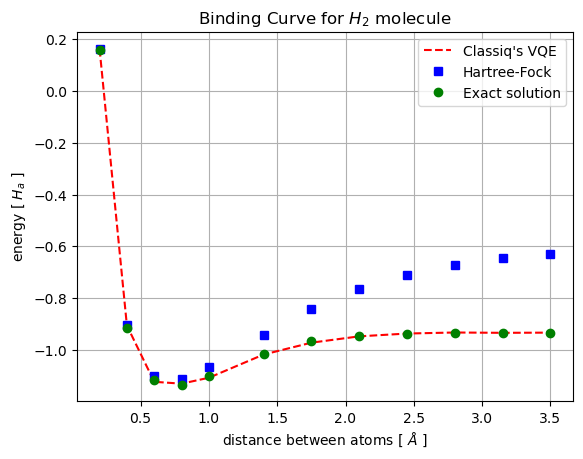

In [11]:
plt.plot(distance, VQE_energy, "r--", 
         distance, HF_energy, "bs", 
         distance, exact_energies, "go")


plt.xlabel(r"distance between atoms [ $\AA$ ]")
plt.ylabel("energy [ $H_a$ ]")
plt.legend(["Classiq's VQE", "Hartree-Fock", "Exact solution"])
plt.title("Binding Curve for $H_{2}$ molecule")
plt.grid()

plt.show()

#### 5. Results:
We have extracted  total energy, the repulsion energy, the hartee-fock energy, the VQE data, the hamiltonian of the system.

In [12]:
# Extract the intermediate results and other relevant data from the results
nuclear_repulsion_energy = results_dict.get('nuclear_repulsion_energy')
total_energy = results_dict.get('total_energy')
hartree_fock_energy = results_dict.get('hartree_fock_energy')
vqe_result = results_dict.get('vqe_result')

intermediate_results = results_dict.get('vqe_result', {}).get('intermediate_results', [])

# Print the energy data first
print(f"Nuclear Repulsion Energy: {nuclear_repulsion_energy}")
print(f"Total Energy: {total_energy}")
print(f"Hartree Fock Energy: {hartree_fock_energy}")
print(f"VQE Energy: {vqe_result}")


operator = chemistry_problem.generate_hamiltonian()
gs_problem = chemistry_problem.update_problem(operator.num_qubits)
print("The hamiltonian is :", operator.show(), sep = "\n")

Nuclear Repulsion Energy: 0.15119348883428574
Total Energy: -0.9331720448208493
Hartree Fock Energy: -0.629820110121346
VQE Energy: {'energy': -1.084365533655135, 'time': 0.46463489532470703, 'solution': None, 'eigenstate': {'1': '(0.6651186454310238+0j)', '0': '(0.7467376965842826+0j)'}, 'reduced_probabilities': {'1': 0.4423828125, '0': 0.5576171875}, 'optimized_circuit_sample_results': {'vendor_format_result': {}, 'counts': {'1': 906, '0': 1142}, 'counts_lsb_right': True, 'probabilities': {}, 'parsed_states': {'1': {'qbv': [1]}, '0': {'qbv': [0]}}, 'histogram': None, 'output_qubits_map': {'qbv': [0]}, 'state_vector': None, 'parsed_state_vector_states': None, 'physical_qubits_map': {'qbv': [0]}, 'num_shots': 2048}, 'intermediate_results': [{'utc_time': '2024-12-11T23:09:53.456489Z', 'iteration_number': 1, 'parameters': [1.6049725266901218], 'mean_all_solutions': -0.7839700315356857, 'solutions': [], 'standard_deviation': 0.0}, {'utc_time': '2024-12-11T23:09:53.482540Z', 'iteration_num

In [13]:
# show(quantum_program)
is_last = (x == distance[-1])

# Synthesize and execute the quantum program: this will give the circuit diagram.
results_dict = synthesize_and_execute(qmod, is_last=is_last)

Opening: https://platform.classiq.io/circuit/f93339d2-276c-43df-a811-0c6a48c78e8a?version=0.61.0


After going to this above link(which is linked via API), We get the quantum circuit for this method:


##### 5.1. We have presented our data in terms of iteration number, error and standard deviation.

In [14]:
# Extracting the intermediate results
intermediate_results = results_dict["vqe_result"]["intermediate_results"]

# Printing the table header
print("Iteration\tParameters\t\tMean All Solutions\tError (\u0394)\tStandard Deviation")
print("="*100)

# Loop through the intermediate results and calculate the errors
previous_mean = None
for result in intermediate_results:
    iteration = result["iteration_number"]
    parameters = ", ".join(f"{p:.6f}" for p in result["parameters"])  # Format parameters to 6 decimal places
    mean_solution = result["mean_all_solutions"]  # Current mean_all_solutions
    error = abs(mean_solution - previous_mean) if previous_mean is not None else 0.0  # Calculate error
    SD = result["standard_deviation"]
    print(f"{iteration}\t\t{parameters}\t\t{mean_solution:.6f}\t\t{error:.6f}\t\t{SD}")
    previous_mean = mean_solution  # Update the previous mean for the next iteration


Iteration	Parameters		Mean All Solutions	Error (Δ)	Standard Deviation
1		1.604973		-0.783970		0.000000		0.0
2		2.604973		-1.052122		0.268152		0.0
3		3.604973		-0.528936		0.523186		0.0
4		3.104973		-0.802298		0.273361		0.0
5		2.354973		-1.084193		0.281895		0.0
6		2.104973		-1.043945		0.040248		0.0
7		2.229973		-1.074748		0.030803		0.0
8		2.417473		-1.084366		0.009617		0.0
9		2.448723		-1.081256		0.003110		0.0
10		2.401848		-1.084069		0.002814		0.0
11		2.425285		-1.082992		0.001078		0.0
12		2.413566		-1.084291		0.001300		0.0
13		2.419426		-1.083814		0.000477		0.0
14		2.416496		-1.084349		0.000535		0.0
15		2.417961		-1.084366		0.000016		0.0
16		2.417523		-1.084366		0.000000		0.0


#### 6. Comments:
Through this project we have seen that how the Variational Quantum Eigensolver (VQE) can accurately approximate molecular ground-state energies and potential energy curves. It gives us more accurate ground state energy compared to classical hartee - fock method. The results demonstrate that VQE provides better accuracy compared to the Hartree-Fock method by effectively capturing electron correlations. This project also give an intuition about the importance of potential energy curves in predicting molecular properties such as bond lengths, binding energies, and spectra, which are crucial for understanding molecular stability and behavior. The use of the Classiq framework simplifies the implementation of quantum algorithms, making it easier to solve complex problems in computational chemistry.

#### 7. References:

1. Peruzzo, A., McClean, J., Shadbolt, P., Yung, M.-H., Zhou, X.-Q., Love, P. J., Aspuru-Guzik, A., & O'Brien, J. L. (2014). [A variational eigenvalue solver on a photonic quantum processor](https://doi.org/10.1038/ncomms5213). *Nature Communications*, **5**, 4213.

2. McClean, J. R., Romero, J., Babbush, R., & Aspuru-Guzik, A. (2016). *The theory of variational hybrid quantum-classical algorithms*. *New Journal of Physics*, **18**, 023023.

3. Kandala, A., Mezzacapo, A., Temme, K., Takita, M., Brink, M., Chow, J. M., & Gambetta, J. M. (2017). *Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets*. *Nature*, **549**, 242-246.

4. Cerezo, M., Arrasmith, A., Babbush, R., Benjamin, S. C., Endo, S., Fujii, K., McClean, J. R., Mitarai, K., Yuan, X., Cincio, L., & Coles, P. J. (2021). *Variational quantum algorithms*. *Nature Reviews Physics*, **3**, 625-644.

5. Naeij, H. R., Mahmoudi, E., Yeganeh, H. D., & Akbari, M. (2024). *Molecular Electronic Structure Calculation via a Quantum Computer*. arXiv preprint.

6. Seeley, J. T., Richard, M. J., & Love, P. J. (2012). *The Bravyi-Kitaev transformation for quantum computation of electronic structure*. *Journal of Chemical Physics*, **137**, 224109.

7. Grimsley, H. R., Economou, S. E., Barnes, E., & Mayhall, N. J. (2019). *An adaptive variational algorithm for exact molecular simulations on a quantum computer*. *Nature Communications*, **10**, 1.

8. [Classiq](https://www.classiq.io/) Platform for running the code.

9. Maomin Qing and Wei Xie, Use VQE to Calculate the Ground Energy of Hydrogen Molecules on IBM Quantum, arXiv:2305.06538v1 (2023). https://arxiv.org/abs/2305.06538

10. Naeij, H. R., Mahmoudi, E., Davoodi Yeganeh, H., & Akbari, M. (2023). Molecular electronic structure calculation via a quantum computer. arXiv. https://arxiv.org/abs/2303.09911